In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
#QUESTION 1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error

In [3]:
#Question 1a
data = pd.read_csv('Graduate_admission.csv')
data.columns = [['', 'GRE', 'TOEFL', 'Uni Rating', 'SOP', 'LOR', 'CGPA', 'Research', 'CoA']]

testdata = pd.read_csv('Graduate_admission_verification.csv')
testdata.columns = data.columns

print('Attributes:', list(data.columns[1:-1]))
print('Output:', list(data.columns[-1]), '(Chance of Admit)')
print('Sample size:', len(data))
print('Methods: Regression for part a and classification for part d & e')

Attributes: [('GRE',), ('TOEFL',), ('Uni Rating',), ('SOP',), ('LOR',), ('CGPA',), ('Research',)]
Output: ['CoA'] (Chance of Admit)
Sample size: 400
Methods: Regression for part a and classification for part d & e


In [4]:
#Question 1b: Regression with GRE and TOEFL as input
X = data[['GRE','TOEFL']]
Y = data[['CoA']]

In [5]:
#Cross validation
from sklearn.model_selection import GridSearchCV
fit_intercept = np.array([True, False])
normalize = np.array([True, False])

paraB = {'fit_intercept':fit_intercept,'normalize':normalize}

regrCV = GridSearchCV(LinearRegression(), paraB, scoring='neg_mean_squared_error', cv=5)
regrCV.fit(X,Y[['CoA']])
regrCV.best_params_

{'fit_intercept': True, 'normalize': True}

In [6]:
#Mean squared error (MSE)
regr = LinearRegression(**regrCV.best_params_)
regr.fit(X,Y[['CoA']])
mean_squared_error(regr.predict(X),Y[['CoA']])

0.006238020894482915

In [7]:
#Sum of squared error (SSE)
mean_squared_error(regr.predict(X),Y[['CoA']])*len(X)

2.495208357793166

In [8]:
#Question 1c
Y.loc[:,'CoA_class'] = np.ceil(Y[['CoA']]/0.2).values #.values to align indices
Y[['CoA_class']] = Y[['CoA_class']].astype(int).astype(str)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [9]:
#Question 1d: KNN with GRE and TOEFL as input
#Cross validation
n_nb = np.arange(1,300,1) # max(n_nb)~len(Y)*(1-1/cv)
w = np.array(['uniform', 'distance'])
paraC = {'n_neighbors':n_nb, 'weights':w}

knnCV = GridSearchCV(KNeighborsClassifier(), paraC, scoring='accuracy', cv=5, return_train_score=False)
knnCV.fit(X,np.ravel(Y[['CoA_class']]))
knnCV.best_params_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_neighbors': 53, 'weights': 'uniform'}

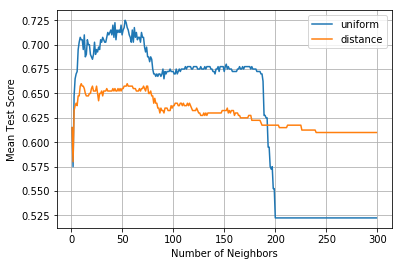

In [10]:
mean_test_score = knnCV.cv_results_['mean_test_score']

plt.figure()
plt.plot(n_nb, mean_test_score[::2],label='uniform')
plt.plot(n_nb, mean_test_score[1::2],label='distance')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Test Score')
plt.legend()
plt.grid()
plt.show()

In [11]:
#Accuracy of KNN
knn = KNeighborsClassifier(**knnCV.best_params_) 
knn.fit(X,np.ravel(Y[['CoA_class']]))
knn.score(X,np.ravel(Y[['CoA_class']]))

0.7325

In [12]:
#Question 1e: Decision tree
X2 = data[['GRE', 'TOEFL', 'Uni Rating', 'SOP', 'LOR', 'CGPA', 'Research']]

In [13]:
#Unpruned tree
dtree0 = DecisionTreeClassifier()
dtree0.fit(X2, np.ravel(Y[['CoA_class']]))
dtree0.score(X2, np.ravel(Y[['CoA_class']]))

1.0

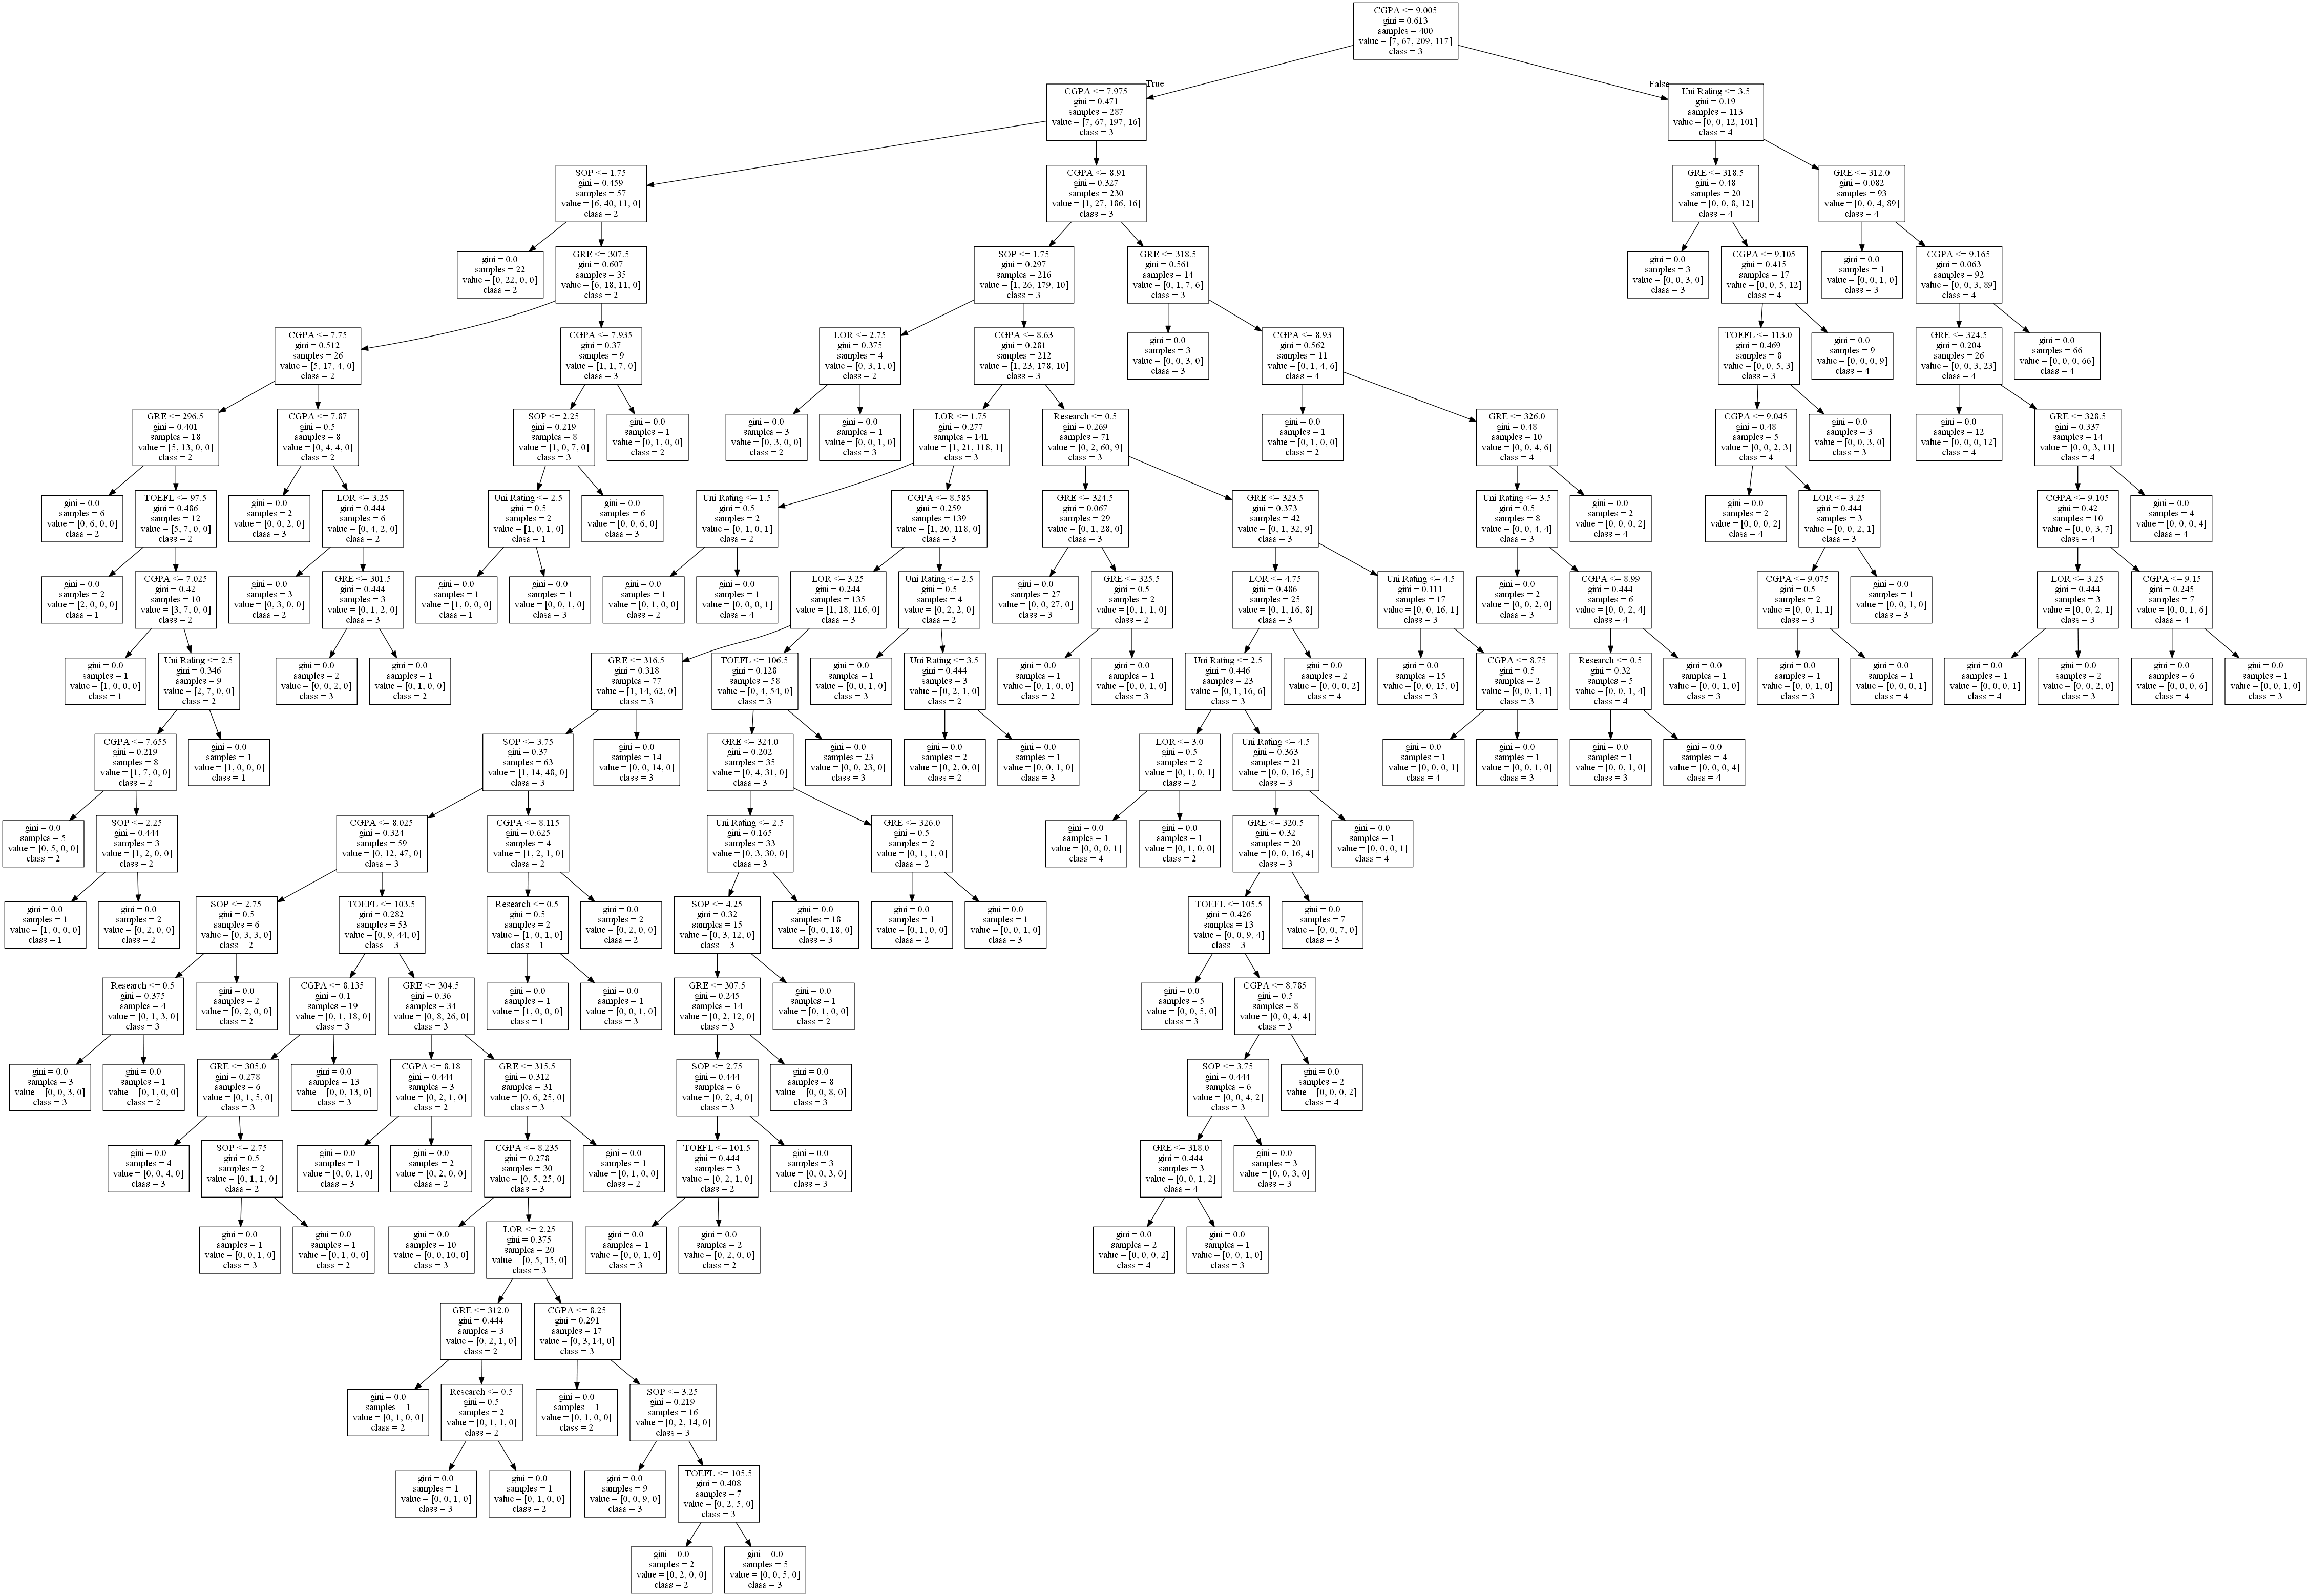

In [14]:
from sklearn import tree
from IPython.display import Image
import graphviz
import pydotplus

feature_names=np.array(['GRE', 'TOEFL', 'Uni Rating', 'SOP', 'LOR', 'CGPA', 'Research'])
class_names=np.array(['1','2','3','4','5'])

dot_data = tree.export_graphviz(dtree0,out_file=None,feature_names=feature_names,class_names=class_names)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [15]:
#Cross validation
#This takes some time to run
criterion = np.array(['gini', 'entropy'])
splitter = np.array(['best', 'random'])
max_depth = np.arange(1,20,1)
max_features = np.arange(2,len(data.columns)-1,1)
min_impurity_decrease = np.arange(0,1e-3,1e-4)

paraE = {'criterion':criterion, 'splitter':splitter, 'max_depth':max_depth,
         'max_features':max_features, 'min_impurity_decrease':min_impurity_decrease} 

dtreeCV = GridSearchCV(DecisionTreeClassifier(), paraE, scoring='accuracy', cv=5, return_train_score=False)
dtreeCV.fit(X2, np.ravel(Y[['CoA_class']]))
dtreeCV.best_params_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 6,
 'min_impurity_decrease': 0.0006000000000000001,
 'splitter': 'best'}

In [16]:
#Pruned tree
dtree = DecisionTreeClassifier(**dtreeCV.best_params_)
dtree.fit(X2, np.ravel(Y[['CoA_class']]))
dtree.score(X2, np.ravel(Y[['CoA_class']]))

0.8575

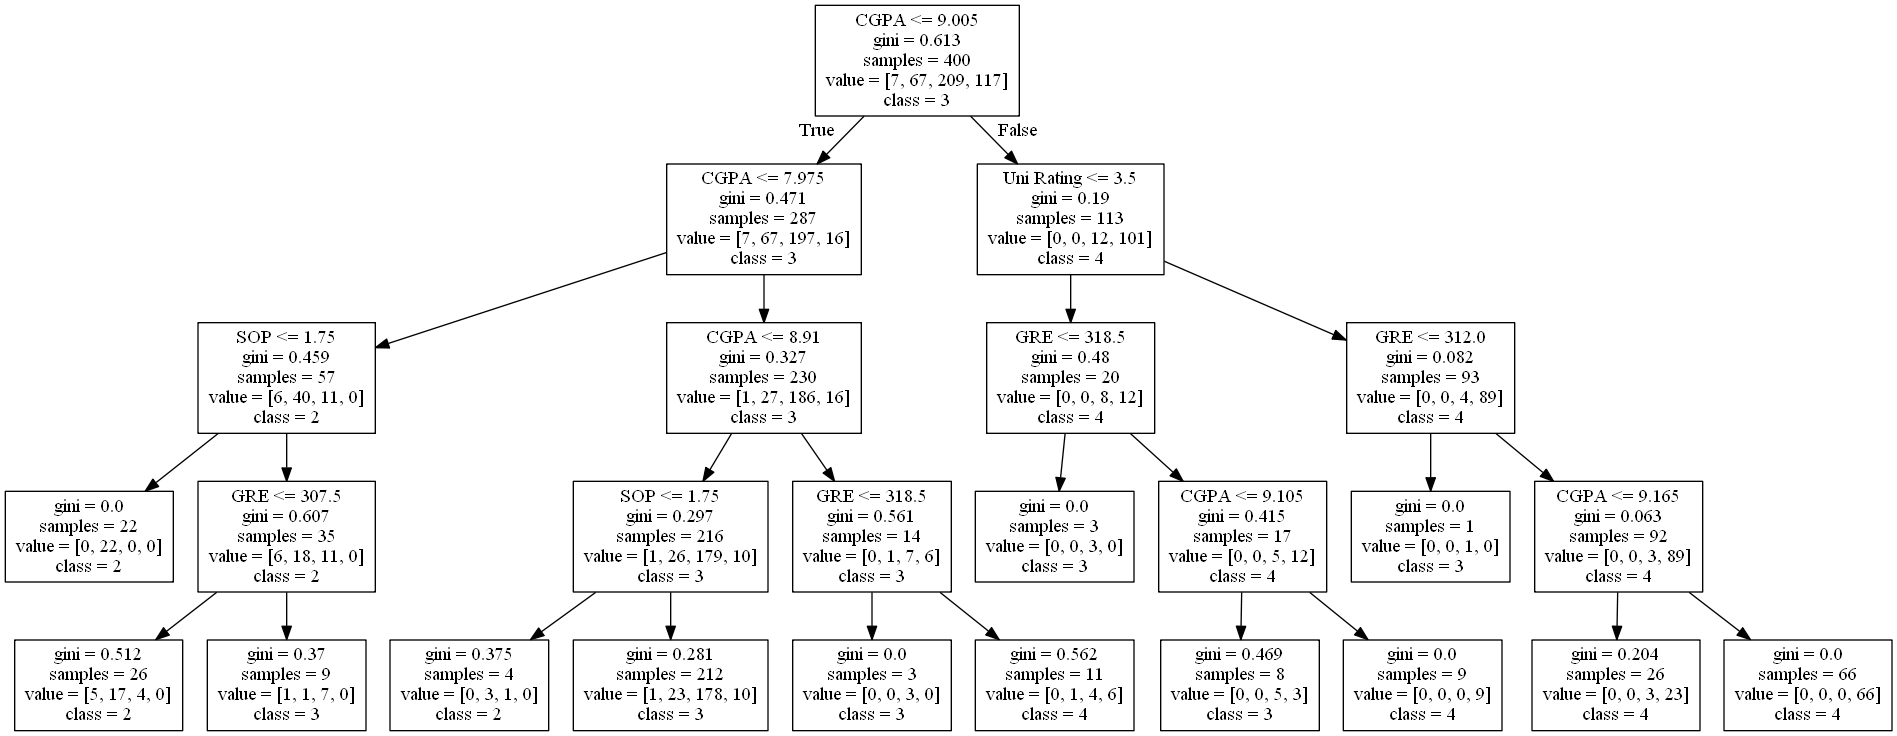

In [17]:
dot_data = tree.export_graphviz(dtree,out_file=None,feature_names=feature_names,class_names=class_names)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [18]:
#Question 1f
Xtest = testdata.loc[400:,['GRE','TOEFL']] #test set overlaps with train set? 
Xtest2 = testdata.loc[400:,['GRE', 'TOEFL', 'Uni Rating', 'SOP', 'LOR', 'CGPA', 'Research']]

Ytest = testdata.loc[400:,'CoA']
Ytest.loc[:,'CoA_class'] = np.ceil(Ytest[['CoA']]/0.2).values
Ytest[['CoA_class']] = Ytest[['CoA_class']].astype(int).astype(str)

In [19]:
print('Regression (2 attributes) SSE on verification set:\t', mean_squared_error(regr.predict(Xtest),Ytest[['CoA']]))
print('KNN (2 attributes) accuracy on verification set:\t', knn.score(Xtest,np.ravel(Ytest[['CoA_class']])))
print('Tree (all attributes) accuracy on verification set:\t', dtree0.score(Xtest2,np.ravel(Ytest[['CoA_class']])))
print('Tree (pruned) accuracy on verification set:\t\t', dtree.score(Xtest2,np.ravel(Ytest[['CoA_class']])))

Regression (2 attributes) SSE on verification set:	 0.0045285681789402395
KNN (2 attributes) accuracy on verification set:	 0.75
Tree (all attributes) accuracy on verification set:	 0.62
Tree (pruned) accuracy on verification set:		 0.78


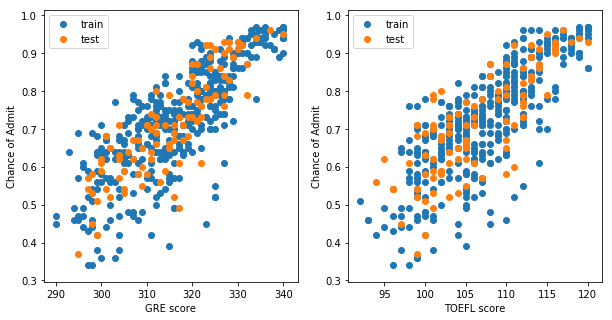

In [20]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(data['GRE'],data['CoA'],label='train')
plt.scatter(testdata.loc[400:,['GRE']],testdata.loc[400:,['CoA']],label='test')
plt.xlabel('GRE score')
plt.ylabel('Chance of Admit')
plt.legend()

plt.subplot(1,2,2)
plt.scatter(data['TOEFL'],data['CoA'],label='train')
plt.scatter(testdata.loc[400:,['TOEFL']],testdata.loc[400:,['CoA']],label='test')
plt.xlabel('TOEFL score')
plt.ylabel('Chance of Admit')
plt.legend()

plt.show()